In [18]:
import numpy as np
import pandas as pd

In [21]:
hormones = pd.read_excel('Hormones/MD data for Wellcome 2026 January.xlsx')
act = pd.read_csv('physiological_with_activity_labels.csv')

/var/folders/p4/y0380b193l1fkn06y5vrd3_c0000gp/T/ipykernel_58681/1682310993.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  act = pd.read_csv('physiological_with_activity_labels.csv')


In [ ]:
print(act.head)
print(hormones.head())

<bound method NDFrame.head of                    timestamp  user    ECG  Accelerometer_X  Accelerometer_Y  \
0        2023-08-09 09:16:42     1  0.018         -295.104          -11.561   
1        2023-08-09 09:16:42     1  0.018         -295.104          -11.561   
2        2023-08-09 09:16:42     1  0.018         -295.104          -11.561   
3        2023-08-09 09:16:43     1  0.029         -289.318          -12.666   
4        2023-08-09 09:16:43     1  0.029         -289.318          -12.666   
...                      ...   ...    ...              ...              ...   
4654528  2025-02-05 15:37:57    22 -0.000          711.798          109.208   
4654529  2025-02-05 15:37:58    22 -0.000          573.396          148.633   
4654530  2025-02-05 15:37:59    22 -0.000          701.083          142.740   
4654531  2025-02-05 15:38:00    22 -0.000          757.338           88.306   
4654532  2025-02-05 15:38:01    22  0.000          765.882           56.945   

         Acceleromete

/var/folders/p4/y0380b193l1fkn06y5vrd3_c0000gp/T/ipykernel_58681/446594874.py:19: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  act = pd.read_csv('physiological_with_activity_labels.csv')



Feature matrix shape: (307, 19)
Samples: 307
Participants: 4

Columns: ['timestamp', 'CAT', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'HRV_mean', 'HRV_std', 'Accel_X_mean', 'Accel_Y_mean', 'Accel_Z_mean', 'Accel_X_std', 'Accel_Y_std', 'Accel_Z_std', 'Accel_magnitude_mean', 'n_samples', 'target_Cortisol', 'target_Melatonin', 'target_Cortisone']

Sample:
            timestamp    CAT  ECG_mean   ECG_std  ECG_min  ECG_max  \
0 2023-08-17 10:01:00  CAT02  0.000000  0.000067   -0.001    0.002   
1 2023-08-17 10:21:00  CAT02  0.000002  0.000058   -0.000    0.002   
2 2023-08-17 10:41:00  CAT02 -0.000002  0.000053   -0.001    0.001   
3 2023-08-17 11:01:00  CAT02  0.000000  0.000094   -0.001    0.002   
4 2023-08-17 11:21:00  CAT02 -0.000004  0.000163   -0.001    0.002   

     HRV_mean    HRV_std  Accel_X_mean  Accel_Y_mean  Accel_Z_mean  \
0  199.988799  37.648537   -362.892762   -115.002936   -831.199023   
1  199.998423  50.856220    292.749245    182.426437   -517.974004   
2  200.054

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Load hormone data (multi-sheet)
sheets = pd.read_excel('Hormones/MD data for Wellcome 2026 January.xlsx', sheet_name=None)

horm_list = []
for sheet_name, df in sheets.items():
    if not str(sheet_name).upper().startswith("CAT"):
        continue
    
    df = df.copy()
    df['CAT'] = sheet_name.strip()
    df = df.rename(columns={df.columns[0]: 'timestamp'})
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    horm_list.append(df)

hormones = pd.concat(horm_list, ignore_index=True)
print(f"Loaded {len(hormones)} hormone samples from {hormones['CAT'].nunique()} participants")

# 2. Load physiological/activity data
act = pd.read_csv('physiological_with_activity_labels.csv')
act['timestamp'] = pd.to_datetime(act['timestamp'], errors='coerce')
act['CAT'] = 'CAT' + act['user'].astype(str).str.zfill(2)

print(f"Loaded {len(act)} physiological samples")
print(f"Activity labels: {act['activity_label'].value_counts()}")

# 3. CREATE WINDOWS (similar to acc_proper_windows.py)
def create_windows_with_hormones(act_df, hormones_df, window_size_sec=30, step_size_sec=10):
    """
    Create fixed-time windows from physiological data,
    then merge nearest hormone values (backward-looking to avoid leakage)
    """
    features_list = []
    
    for cat in act_df['CAT'].unique():
        cat_act = act_df[act_df['CAT'] == cat].sort_values('timestamp').copy()
        cat_horm = hormones_df[hormones_df['CAT'] == cat].sort_values('timestamp').copy()
        
        if len(cat_act) < window_size_sec * 3:  # Need enough data
            continue
        
        # Create time-based windows
        start_time = cat_act['timestamp'].min()
        end_time = cat_act['timestamp'].max()
        
        current_time = start_time
        window_delta = pd.Timedelta(seconds=window_size_sec)
        step_delta = pd.Timedelta(seconds=step_size_sec)
        
        while current_time < end_time:
            window_end = current_time + window_delta
            window_data = cat_act[
                (cat_act['timestamp'] >= current_time) & 
                (cat_act['timestamp'] < window_end)
            ]
            
            if len(window_data) < 10:  # Skip sparse windows
                current_time += step_delta
                continue
            
            # Get majority activity label in window (for classification target)
            activity_counts = window_data['activity_label'].value_counts()
            if len(activity_counts) == 0:
                current_time += step_delta
                continue
            
            majority_label = activity_counts.index[0]
            label_purity = activity_counts.iloc[0] / len(window_data)
            
            # Skip ambiguous windows
            if label_purity < 0.6:
                current_time += step_delta
                continue
            
            # Extract physiological features
            window_center = current_time + window_delta / 2
            
            features = {
                'timestamp': window_center,
                'CAT': cat,
                'activity_label': majority_label,
                
                # ECG features
                'ECG_mean': window_data['ECG'].mean(),
                'ECG_std': window_data['ECG'].std(),
                'ECG_min': window_data['ECG'].min(),
                'ECG_max': window_data['ECG'].max(),
                
                # HRV features
                'HRV_mean': window_data['HRV'].mean(),
                'HRV_std': window_data['HRV'].std(),
                'HRV_min': window_data['HRV'].min(),
                'HRV_max': window_data['HRV'].max(),
                
                # Accelerometer features
                'Accel_X_mean': window_data['Accelerometer_X'].mean(),
                'Accel_Y_mean': window_data['Accelerometer_Y'].mean(),
                'Accel_Z_mean': window_data['Accelerometer_Z'].mean(),
                'Accel_X_std': window_data['Accelerometer_X'].std(),
                'Accel_Y_std': window_data['Accelerometer_Y'].std(),
                'Accel_Z_std': window_data['Accelerometer_Z'].std(),
                
                # Movement magnitude
                'Accel_magnitude_mean': np.sqrt(
                    window_data['Accelerometer_X']**2 + 
                    window_data['Accelerometer_Y']**2 + 
                    window_data['Accelerometer_Z']**2
                ).mean(),
                
                'n_samples': len(window_data),
                'label_purity': label_purity
            }
            
            # Find nearest PAST hormone values (backward-looking, max 60 min ago)
            past_hormones = cat_horm[
                (cat_horm['timestamp'] <= window_center) &
                (cat_horm['timestamp'] >= window_center - pd.Timedelta(minutes=60))
            ]
            
            if len(past_hormones) > 0:
                # Get most recent hormone sample
                most_recent = past_hormones.iloc[-1]
                
                # Add hormone features
                for col in ['Cortisol', 'Melatonin', 'Cortisone', 'cortisol', 'cortisone', 'melatonin']:
                    if col in most_recent.index:
                        features[f'hormone_{col}'] = most_recent[col]
                        features[f'hormone_{col}_time_diff_min'] = (window_center - most_recent['timestamp']).total_seconds() / 60
            
            features_list.append(features)
            current_time += step_delta
    
    return pd.DataFrame(features_list)

# 4. Create windowed dataset
print("\nCreating windows...")
dataset = create_windows_with_hormones(act, hormones, window_size_sec=30, step_size_sec=15)

print(f"\nWindowed dataset shape: {dataset.shape}")
print(f"Activity label distribution:\n{dataset['activity_label'].value_counts()}")
print(f"Samples with hormones: {dataset['hormone_Cortisol'].notna().sum() if 'hormone_Cortisol' in dataset.columns else 0}")

# 5. Prepare for XGBoost
# Drop rows with rare activity labels
keep_labels = ['lying', 'sit', 'stand']
dataset = dataset[dataset['activity_label'].isin(keep_labels)].copy()

min_samples = 20
label_counts = dataset['activity_label'].value_counts()
valid_labels = label_counts[label_counts >= min_samples].index
dataset = dataset[dataset['activity_label'].isin(valid_labels)].copy()

print(f"\nAfter filtering rare labels: {len(dataset)} samples")
print(f"Classes: {sorted(dataset['activity_label'].unique())}")

# Define features
feature_cols = [c for c in dataset.columns if c not in ['timestamp', 'CAT', 'activity_label', 'label_purity']]
print(f"\nFeatures: {len(feature_cols)}")

X = dataset[feature_cols].copy()
y = dataset['activity_label'].copy()
groups = dataset['CAT'].copy()

# Handle missing values
# Separate physiological and hormone features
hormone_cols = [c for c in feature_cols if 'hormone' in c.lower()]
physio_cols = [c for c in feature_cols if 'hormone' not in c.lower()]

print(f"\nPhysiological features: {len(physio_cols)}")
print(f"Hormone features: {len(hormone_cols)}")

# Check missing data
print(f"\nMissing values in physiological features: {X[physio_cols].isna().sum().sum()}")
print(f"Missing values in hormone features: {X[hormone_cols].isna().sum().sum()}")

# Option 1: Keep only samples WITH hormone data
has_any_hormone = X[hormone_cols].notna().any(axis=1)
print(f"\nSamples with at least one hormone value: {has_any_hormone.sum()} / {len(X)} ({has_any_hormone.sum()/len(X)*100:.1f}%)")

if has_any_hormone.sum() > 1000:  # Only if we have enough samples
    print("\n=== TRAINING WITH HORMONE FEATURES (samples with hormone data only) ===")
    
    # Filter to only samples with hormones
    dataset_with_horm = dataset[has_any_hormone].copy()
    X = dataset_with_horm[feature_cols].copy()
    y = dataset_with_horm['activity_label'].copy()
    groups = dataset_with_horm['CAT'].copy()
    
    # Let XGBoost handle remaining NaNs
    print(f"Dataset size with hormones: {len(X)}")
    print(f"NaN values: {X.isna().sum().sum()}")
else:
    print("\n=== NOT ENOUGH HORMONE DATA - TRAINING WITHOUT HORMONES ===")
    X = X[physio_cols].copy()
    X = X.fillna(0)

# Check class balance
print(f"\nClass distribution:")
for label, count in dataset['activity_label'].value_counts().items():
    print(f"  {label}: {count} ({count/len(dataset)*100:.1f}%)")

# **ENCODE LABELS TO INTEGERS**
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nLabel mapping:")
for label, code in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {label} -> {code}")

# 6. Train/test split (participant-based like model_new.py)
from sklearn.model_selection import LeavePOut

# Leave-One-Participant-Out evaluation
participants = groups.unique()
print(f"\nParticipants: {len(participants)}")

all_preds = []
all_true = []
all_test_cats = []

for test_cat in participants:
    train_mask = groups != test_cat
    test_mask = groups == test_cat
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]  # Use encoded labels
    
    if len(y_test) < 5:
        continue
    
    # Train XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    all_preds.extend(preds)
    all_true.extend(y_test)
    all_test_cats.extend([test_cat] * len(y_test))
    
    acc = accuracy_score(y_test, preds)
    print(f"  {test_cat}: accuracy={acc:.3f}, n_test={len(y_test)}")


   

Loaded 388 hormone samples from 5 participants


/var/folders/p4/y0380b193l1fkn06y5vrd3_c0000gp/T/ipykernel_61099/589356519.py:26: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  act = pd.read_csv('physiological_with_activity_labels.csv')


Loaded 4654533 physiological samples
Activity labels: activity_label
sit                  848147
lying                261600
stand                249916
light_activity       203764
moderate_activity     47220
Name: count, dtype: int64

Creating windows...

Windowed dataset shape: (47909, 30)
Activity label distribution:
activity_label
sit                  23784
lying                 9476
stand                 7193
light_activity        5913
moderate_activity     1543
Name: count, dtype: int64
Samples with hormones: 4051

After filtering rare labels: 40453 samples
Classes: ['lying', 'sit', 'stand']

Features: 26

Physiological features: 16
Hormone features: 10

Missing values in physiological features: 0
Missing values in hormone features: 367949

Samples with at least one hormone value: 4995 / 40453 (12.3%)

=== TRAINING WITH HORMONE FEATURES (samples with hormone data only) ===
Dataset size with hormones: 4995
NaN values: 13369

Class distribution:
  sit: 23784 (58.8%)
  lying: 9476 (

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]


=== OVERALL RESULTS ===
Accuracy: 0.529

Classification Report:
              precision    recall  f1-score   support

       lying       0.33      0.22      0.27      9476
         sit       0.65      0.79      0.71     23784
       stand       0.10      0.07      0.08      7193

    accuracy                           0.53     40453
   macro avg       0.36      0.36      0.35     40453
weighted avg       0.48      0.53      0.50     40453


Confusion Matrix (Raw Counts):
       lying    sit  stand
lying   2122   4906   2448
sit     2739  18756   2289
stand   1639   5052    502

Normalized Confusion Matrix (by row - recall for each class):
       lying    sit  stand
lying  0.224  0.518  0.258
sit    0.115  0.789  0.096
stand  0.228  0.702  0.070

Confusion matrices saved to 'confusion_matrices.png'


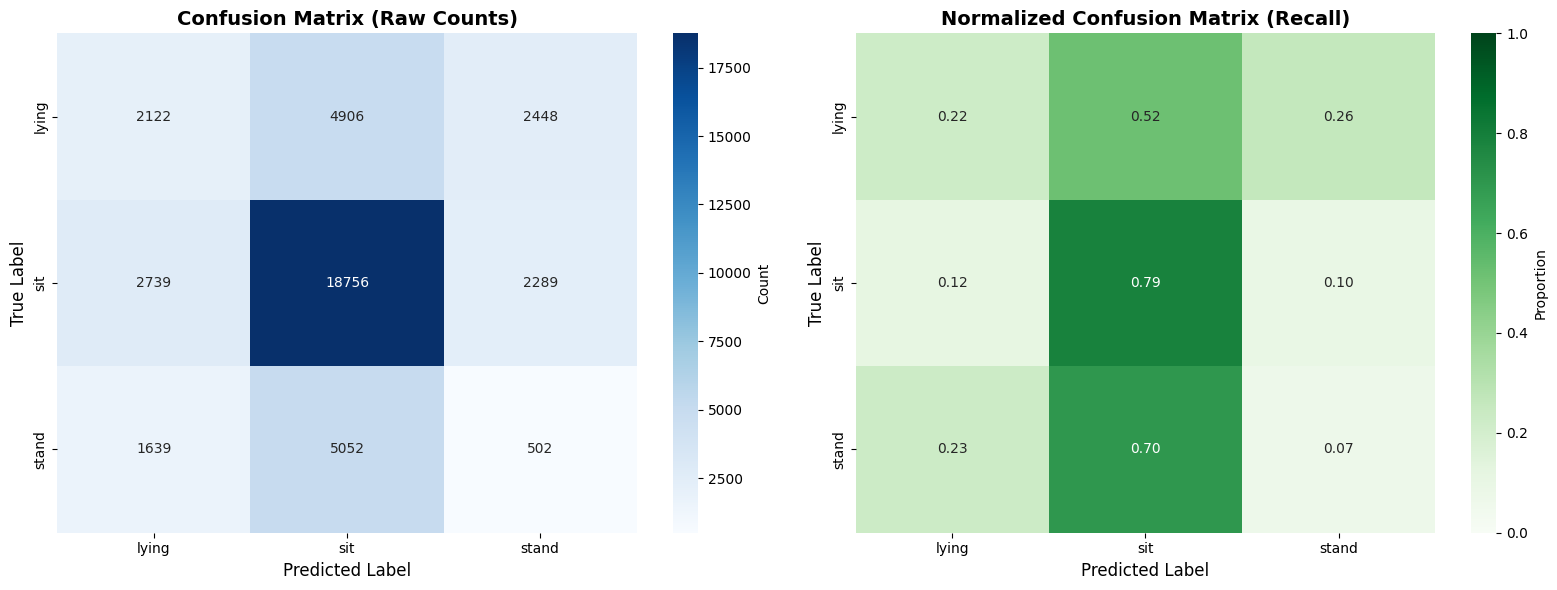

In [6]:
if len(all_true) > 0:
    print(f"\n=== OVERALL RESULTS ===")
    print(f"Accuracy: {accuracy_score(all_true, all_preds):.3f}")
    
    # Decode predictions back to original labels for readable report
    all_true_labels = label_encoder.inverse_transform(all_true)
    all_pred_labels = label_encoder.inverse_transform(all_preds)
    
    print(f"\nClassification Report:")
    print(classification_report(all_true_labels, all_pred_labels))
    
    # Raw confusion matrix
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    
    cm = confusion_matrix(all_true_labels, all_pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    print(f"\nConfusion Matrix (Raw Counts):")
    print(cm_df)
    
    # Normalized confusion matrix (by true label)
    cm_normalized = confusion_matrix(all_true_labels, all_pred_labels, labels=label_encoder.classes_, normalize='true')
    cm_norm_df = pd.DataFrame(cm_normalized, index=label_encoder.classes_, columns=label_encoder.classes_)
    print(f"\nNormalized Confusion Matrix (by row - recall for each class):")
    print(cm_norm_df.round(3))
    
    # Visualize with matplotlib if available
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Raw confusion matrix
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
        axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Predicted Label', fontsize=12)
        axes[0].set_ylabel('True Label', fontsize=12)
        
        # Normalized confusion matrix
        sns.heatmap(cm_norm_df, annot=True, fmt='.2f', cmap='Greens', ax=axes[1], 
                    vmin=0, vmax=1, cbar_kws={'label': 'Proportion'})
        axes[1].set_title('Normalized Confusion Matrix (Recall)', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Predicted Label', fontsize=12)
        axes[1].set_ylabel('True Label', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        print(f"\nConfusion matrices saved to 'confusion_matrices.png'")
        plt.show()
    except ImportError:
        print("\nMatplotlib/Seaborn not available - skipping visualization")


=== FEATURE ANALYSIS ===

1. Training model on all data for feature importance...

Top 20 Most Important Features:
                 feature  importance
15             n_samples    0.188380
8           Accel_X_mean    0.149872
12           Accel_Y_std    0.129082
9           Accel_Y_mean    0.092089
6                HRV_min    0.078859
10          Accel_Z_mean    0.074616
14  Accel_magnitude_mean    0.057706
13           Accel_Z_std    0.048385
11           Accel_X_std    0.043577
1                ECG_std    0.032281
5                HRV_std    0.028003
7                HRV_max    0.024581
2                ECG_min    0.021408
3                ECG_max    0.014572
0               ECG_mean    0.012837
4               HRV_mean    0.003752

Bottom 10 Least Important Features:
                 feature  importance
14  Accel_magnitude_mean    0.057706
13           Accel_Z_std    0.048385
11           Accel_X_std    0.043577
1                ECG_std    0.032281
5                HRV_std    0.028

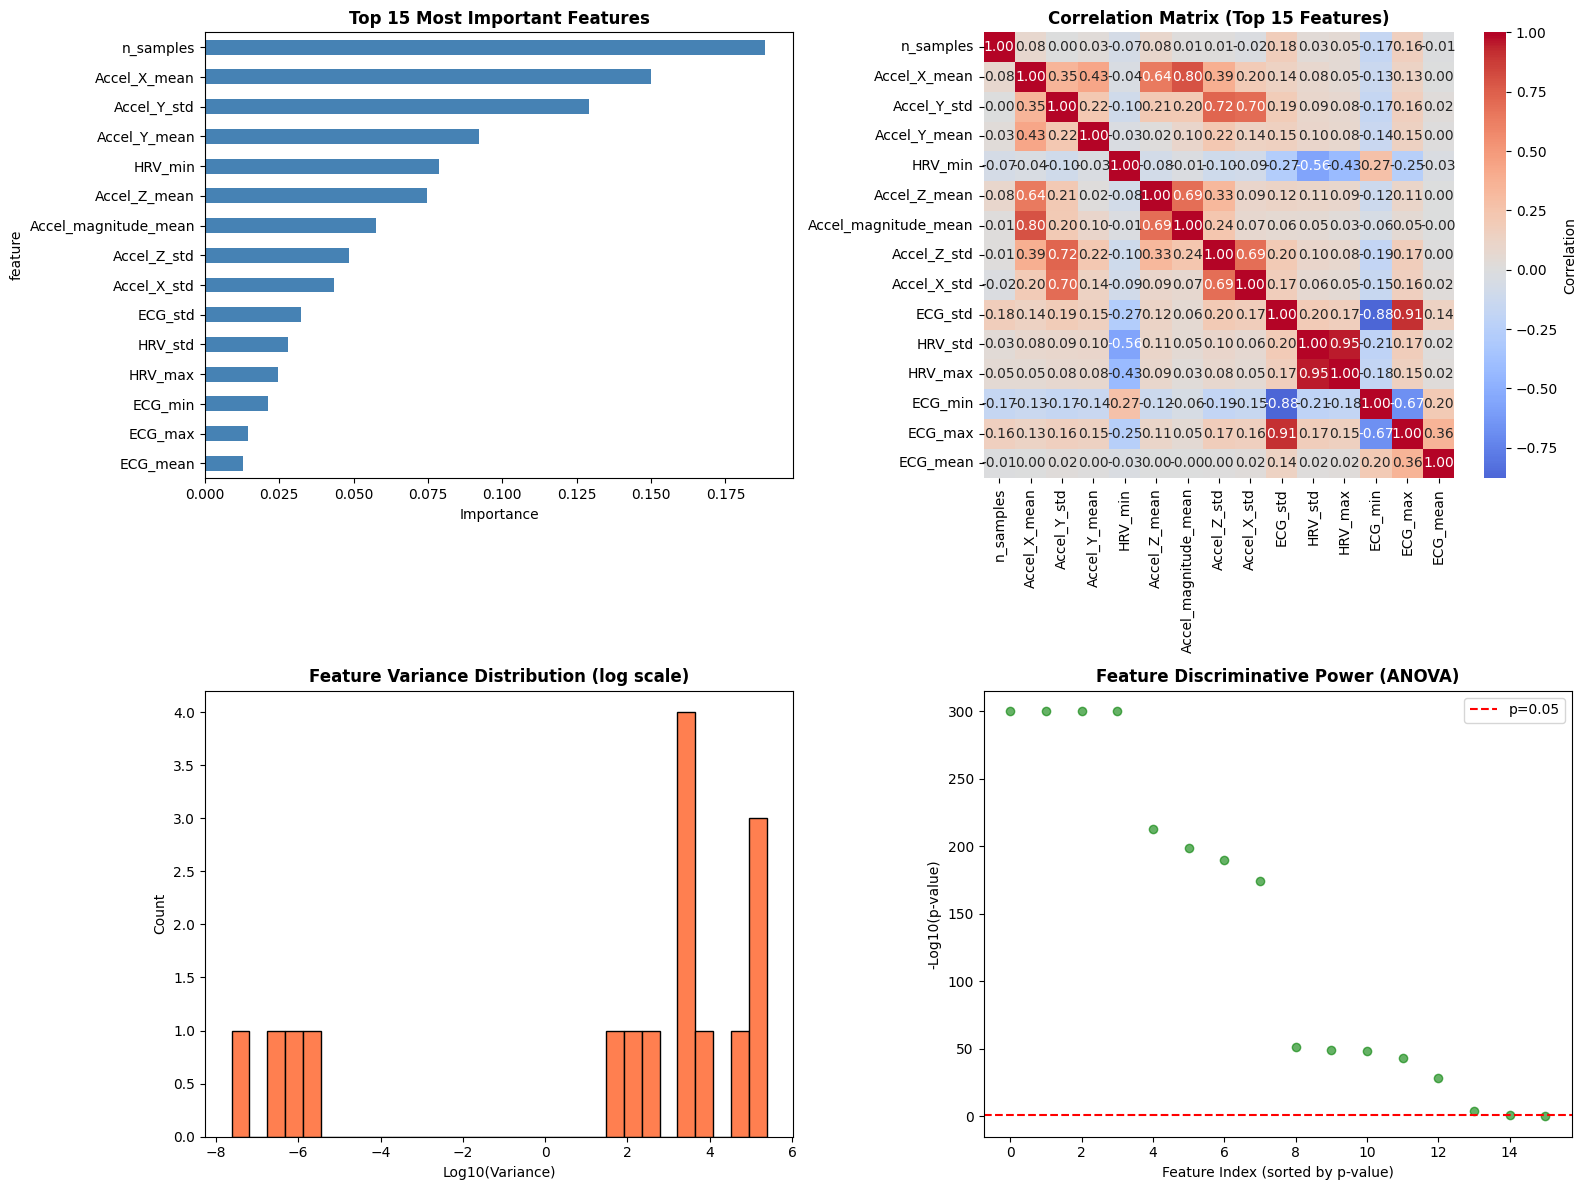


=== FEATURE ELIMINATION RECOMMENDATIONS ===

Low importance features (< 0.001): 0
[]

Low variance features (< 0.01): 4
['ECG_max', 'ECG_min', 'ECG_std', 'ECG_mean']

Non-discriminative features (p > 0.05): 2
['ECG_mean', 'HRV_mean']


Features in ALL three categories (strong candidates for removal): 0

Full feature analysis exported to 'feature_analysis_summary.csv'


In [7]:
# === FEATURE ANALYSIS ===
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== FEATURE ANALYSIS ===")

# 1. Feature importance from XGBoost (train on all data for analysis)
print("\n1. Training model on all data for feature importance...")
model_full = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_full.fit(X, y_encoded)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_full.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

print("\nBottom 10 Least Important Features:")
print(feature_importance.tail(10))

# 2. Feature correlation matrix
print("\n2. Computing feature correlations...")
correlation_matrix = X.corr()

# Find highly correlated features (potential redundancy)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

if len(high_corr_pairs) > 0:
    print(f"\nHighly correlated feature pairs (|r| > 0.9): {len(high_corr_pairs)}")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    print(high_corr_df)
else:
    print("\nNo highly correlated feature pairs found (|r| > 0.9)")

# 3. Feature variance
print("\n3. Feature variance analysis...")
feature_variance = pd.DataFrame({
    'feature': X.columns,
    'variance': X.var(),
    'std': X.std()
}).sort_values('variance', ascending=False)

print("\nFeatures with lowest variance (may not be informative):")
print(feature_variance.tail(10))

# 4. Feature distribution by class
print("\n4. Feature distributions by activity class...")
X_with_labels = X.copy()
X_with_labels['activity_label'] = y

# Statistical test for each feature
from scipy.stats import f_oneway

feature_anova = []
for col in X.columns:
    groups = [X_with_labels[X_with_labels['activity_label'] == label][col].dropna() 
              for label in y.unique()]
    
    # Remove empty groups
    groups = [g for g in groups if len(g) > 0]
    
    if len(groups) >= 2:
        f_stat, p_value = f_oneway(*groups)
        feature_anova.append({
            'feature': col,
            'f_statistic': f_stat,
            'p_value': p_value
        })

anova_df = pd.DataFrame(feature_anova).sort_values('p_value')
print("\nFeatures most discriminative between classes (ANOVA):")
print(anova_df.head(15))

print("\nFeatures least discriminative (may not help classification):")
print(anova_df.tail(10))

# 5. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Feature importance bar plot
top_n = 15
feature_importance.head(top_n).plot(
    x='feature', y='importance', kind='barh', 
    ax=axes[0, 0], legend=False, color='steelblue'
)
axes[0, 0].set_title(f'Top {top_n} Most Important Features', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].invert_yaxis()

# Correlation heatmap (top features only)
top_features = feature_importance.head(15)['feature'].tolist()
corr_subset = X[top_features].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0, 1], cbar_kws={'label': 'Correlation'})
axes[0, 1].set_title('Correlation Matrix (Top 15 Features)', fontsize=12, fontweight='bold')

# Feature variance distribution
feature_variance['log_variance'] = np.log10(feature_variance['variance'] + 1e-10)
axes[1, 0].hist(feature_variance['log_variance'], bins=30, color='coral', edgecolor='black')
axes[1, 0].set_title('Feature Variance Distribution (log scale)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Log10(Variance)')
axes[1, 0].set_ylabel('Count')

# ANOVA p-values
anova_df['log_p_value'] = -np.log10(anova_df['p_value'] + 1e-300)
axes[1, 1].scatter(range(len(anova_df)), anova_df['log_p_value'], alpha=0.6, color='green')
axes[1, 1].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
axes[1, 1].set_title('Feature Discriminative Power (ANOVA)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Feature Index (sorted by p-value)')
axes[1, 1].set_ylabel('-Log10(p-value)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('feature_analysis.png', dpi=300, bbox_inches='tight')
print("\n\nFeature analysis plots saved to 'feature_analysis.png'")
plt.show()

# 6. Summary recommendations
print("\n=== FEATURE ELIMINATION RECOMMENDATIONS ===")

# Features to potentially remove
low_importance = feature_importance[feature_importance['importance'] < 0.001]['feature'].tolist()
low_variance = feature_variance[feature_variance['variance'] < 0.01]['feature'].tolist()
non_discriminative = anova_df[anova_df['p_value'] > 0.05]['feature'].tolist()

print(f"\nLow importance features (< 0.001): {len(low_importance)}")
if len(low_importance) <= 10:
    print(low_importance)
else:
    print(f"  {low_importance[:5]} ... (showing first 5)")

print(f"\nLow variance features (< 0.01): {len(low_variance)}")
if len(low_variance) <= 10:
    print(low_variance)

print(f"\nNon-discriminative features (p > 0.05): {len(non_discriminative)}")
if len(non_discriminative) <= 10:
    print(non_discriminative)

# Features appearing in multiple "bad" lists
candidates_for_removal = set(low_importance) & set(low_variance) & set(non_discriminative)
print(f"\n\nFeatures in ALL three categories (strong candidates for removal): {len(candidates_for_removal)}")
if len(candidates_for_removal) > 0:
    print(list(candidates_for_removal))

# Export feature analysis
feature_summary = feature_importance.merge(
    feature_variance[['feature', 'variance']], on='feature'
).merge(
    anova_df[['feature', 'p_value']], on='feature', how='left'
)
feature_summary.to_csv('feature_analysis_summary.csv', index=False)
print(f"\nFull feature analysis exported to 'feature_analysis_summary.csv'")